In [1]:
from o2s.models.object_2_sphere import Mesh2Drag
from o2s.datasets.drag_dataset import DragDataset
from o2s.datasets.transforms.general import Compose
from o2s.datasets.transforms.radar import Log, Abs, Normalize, Center
from o2s.datasets.transforms.mesh import MeshNormalize

import numpy as np
import matplotlib.pyplot as plt
from torch_harmonics import plotting
from torch_geometric.loader import DataLoader
import xarray
import torch
from torch import nn
from pathlib import Path

from hydra_zen import load_from_yaml, instantiate, get_target
from mlflow import MlflowClient, set_tracking_uri

In [2]:
set_tracking_uri('/home/colin/hdd/workspace/object2sphere/datasets/out/mlflow')
runs = MlflowClient().search_runs(
    experiment_ids="429858339920414921",
)

In [3]:
output_dir = runs[0].data.params['output_dir']
print(output_dir)
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
equiformer = get_target(cfg.module)
equiformer = equiformer.load_from_checkpoint(
    output_dir + '/last.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

/home/colin/hdd/workspace/object2sphere/datasets/out/hydra/drag/2024-09-21/16-10-37


/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/

In [4]:
output_dir = runs[1].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
o2s = get_target(cfg.module)
o2s = o2s.load_from_checkpoint(
    output_dir + '/last.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

/home/colin/hdd/workspace/object2sphere/datasets/out/hydra/drag/2024-09-21/15-41-05


/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/

In [5]:
output_dir = runs[0].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
test_ds_fp = '/home/colin/hdd/workspace/datasets/drag_sweep/'
ds = DragDataset(
    test_ds_fp,
    'train',
    seed=0,
    transform=instantiate(cfg.test_dataset.transform),
    shuffle_before_split=False,
    testing=True
)

In [6]:
dl = DataLoader(ds, batch_size=430, num_workers=0, shuffle=False)
itr = iter(dl)

In [7]:
mesh, flight_conds, coords, drag = next(itr)

In [10]:
with torch.no_grad():
    equiformer_pred, _ = equiformer((mesh.cuda(), flight_conds.cuda(), coords.cuda()))
    o2s_pred, w = o2s((mesh.cuda(), flight_conds.cuda(), coords.cuda()))

Text(0, 0.5, 'Angle of side slip [deg]')

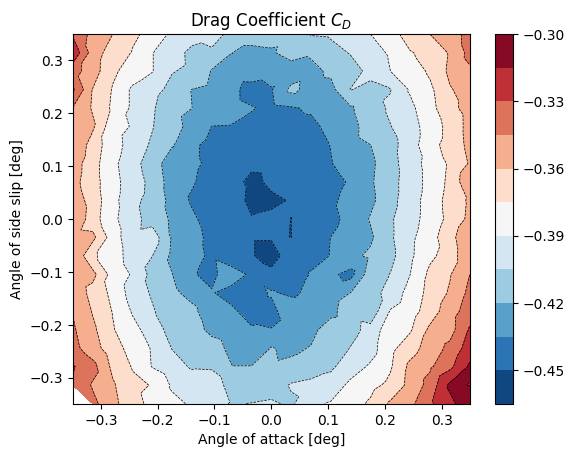

In [11]:
x = np.pi/ 2 - coords[:,0]
y = coords[:,1]
for i in range(coords[:,1].shape[0]):
    if y[i] > np.pi:
        y[i] -= 2* np.pi
z = o2s_pred.cpu().squeeze().numpy()

fig, ax1, = plt.subplots(nrows=1)
ax1.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax1.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax1)
ax1.set_title(r'Drag Coefficient $C_D$')
#jax1.set(xlim=(0, 20), ylim=(0, 20))  # just 0 to 20 b/c of symmetry
ax1.set_xlabel(r'Angle of attack [deg]')
ax1.set_ylabel(r'Angle of side slip [deg]')

Text(0, 0.5, 'Angle of side slip [deg]')

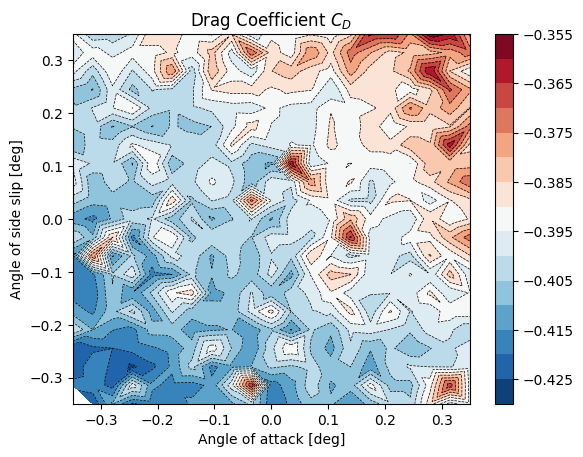

In [12]:
x = np.pi/ 2 - coords[:,0]
y = coords[:,1]
for i in range(coords[:,1].shape[0]):
    if y[i] > np.pi:
        y[i] -= 2* np.pi
z = equiformer_pred.cpu().squeeze().numpy()

fig, ax1, = plt.subplots(nrows=1)
ax1.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax1.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax1)
ax1.set_title(r'Drag Coefficient $C_D$')
#jax1.set(xlim=(0, 20), ylim=(0, 20))  # just 0 to 20 b/c of symmetry
ax1.set_xlabel(r'Angle of attack [deg]')
ax1.set_ylabel(r'Angle of side slip [deg]')

Text(0, 0.5, 'theta')

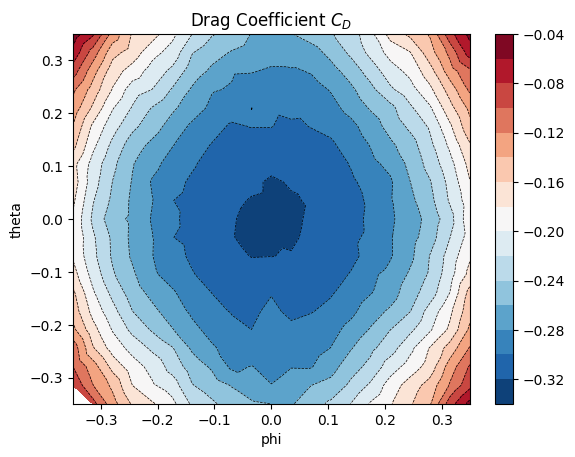

In [13]:
z = drag.cpu().squeeze()

fig, ax1, = plt.subplots(nrows=1)
ax1.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax1.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax1)
ax1.set_title(r'Drag Coefficient $C_D$')
#jax1.set(xlim=(0, 20), ylim=(0, 20))  # just 0 to 20 b/c of symmetry
ax1.set_xlabel(r'phi')
ax1.set_ylabel(r'theta')

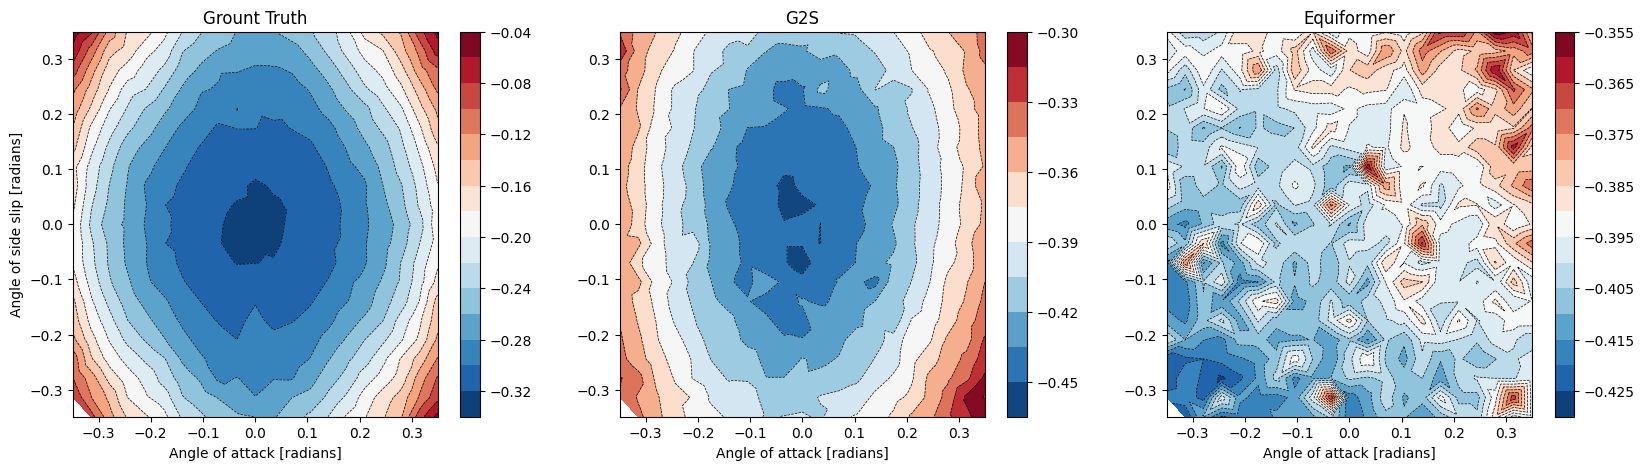

In [26]:
x = np.pi/ 2 - coords[:,0]
y = coords[:,1]
for i in range(coords[:,1].shape[0]):
    if y[i] > np.pi:
        y[i] -= 2* np.pi
        
z0 = drag.cpu().squeeze().numpy()
z1 = o2s_pred.cpu().squeeze().numpy()
z2 = equiformer_pred.cpu().squeeze().numpy()

fig, ax, = plt.subplots(ncols=3, figsize=(20,5))
ax[0].tricontour(x, y, z0, levels=14, linewidths=0.5, colors='k')
cntr_gt = ax[0].tricontourf(x, y, z0, levels=14, cmap="RdBu_r")

ax[1].tricontour(x, y, z1, levels=14, linewidths=0.5, colors='k')
cntr_g2s = ax[1].tricontourf(x, y, z1, levels=14, cmap="RdBu_r")

ax[2].tricontour(x, y, z2, levels=14, linewidths=0.5, colors='k')
cntr_equi = ax[2].tricontourf(x, y, z2, levels=14, cmap="RdBu_r")

fig.colorbar(cntr_gt, ax=ax[0])
ax[0].set_title(r'Ground Truth')
ax[0].set_xlabel(r'Theta [radians]')
ax[0].set_ylabel(r'Phi [radians]')

fig.colorbar(cntr_g2s, ax=ax[1])
ax[1].set_title(r'G2S')
ax[1].set_xlabel(r'Phi [radians]')

fig.colorbar(cntr_equi, ax=ax[2])
ax[2].set_title(r'Equiformer')
ax[2].set_xlabel(r'Phi [radians]')

plt.savefig('drag_compare.png')